In [5]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym

Our original value function is
$$
V(S^* , M) = 
\mathbb{E}_{( S^* , M) }\big[ 
\sum_{n=0}^{T-1} e^{-rn} [f_X(S^*_{n+1} , S^*_n) + S^*_{n+1} e^{ M_{n+1}}f_Y(S^*_{n+1} , 
S^*_n)] + e^{-rT} W_T
\big]
$$

with $ T = \inf \{ n \geq 0 \mid \ln S^*_n = \ln S^*_0 \pm \delta \}$ .
Let $N \in \mathbb{N} $ s.t $\ln P_u  - \ln P_l = (N+1)\delta $ . By suitable enumeration , the above Bellman equation can be
rewritten as:

$$
V(n) = \begin{cases}
A(n) \big[ V(n+N+1) + f_X(n) \big] + B(n) \big[  V(n-1) + S(n-1) f_Y(n) \big] 
& \text{if} \; 0< n \leq N 
\\
A(n) \big[ V(n+1) + f_X(n) \big] + B(n) \big[  V(n-N) + S(n-N-1) f_Y(n) \big]
& \text{if} \; N+1 \leq n < 2N+1 
\end{cases}
$$

or in the matrix form : ( $0 <n_1 \leq N$ , $N+1 \leq n_2 < 2N+1$ ) 

$$
\small
\begin{pmatrix}
V(0) \\
\vdots \\
V(n_1) \\
\vdots \\
V(n_2) \\
\vdots \\
V(2N+1)
\end{pmatrix}
=
\begin{pmatrix}
1      &    0    & \ldots &   0   &  \ldots&   0    & 0 \\
\vdots \\
  0    & \ldots  &  \overbrace{B(n_1)}^{n_1-1\; \text{th column}} & \ldots & 
  \overbrace{A(n_1)}^{n_1 +N+1 \;\text{th column} } & \ldots & 0 \\ 
\vdots \\
  0    & \ldots  &  \ldots &  \overbrace{B(n_2)}^{n_2-N\; \text{th column}} &
 \ldots &  \overbrace{A(n_2)}^{n_2+1 \;\text{th column} } &  0 \\ 
\vdots \\
  0    &    0    &  0    &   0    &  0  &   0     &  1 
\end{pmatrix}
\begin{pmatrix}
V(0) \\
\vdots \\
V(n_1) \\
\vdots \\
V(n_2) \\
\vdots \\
V(2N+1)
\end{pmatrix}
+
\begin{pmatrix}
0\\
\vdots \\
A(n_1)  f_X(n_1) + B(n_1) S(n_1-1) f_Y(n_1) \\
\vdots \\
A(n_2)  f_X(n_2) + B(n_2) S(n_2-N-1) f_Y(n_2) \\
\vdots \\
0
\end{pmatrix}
$$
and the boundary conditions :
$$
V(2N+1) = W_u \quad , \quad V(0) = W_l
$$

## Computation of $A(n)$ and $B(n)$

### Formula check
Compute
$\mathbb{E}_{(S^*,M)}(e^{-r\tau} \; ; \; S^*_\tau = S^*_0 e^\delta) $
and $\mathbb{E}_{(S^*,M)}(e^{-r\tau} \; ; \; S^*_\tau = S^*_0 e^{-\delta} )$ with $\tau = \{ n \geq 0 \mid S^*_n \neq S^*_0\}$
or equivalently let $\{ X_n\}_{n \geq 0}$ be a SRW with forward probability $p>0 $ and compute
$ \mathbb{E}_{x}(e^{-r\tau} \; ; \; X_\tau =  k+1)$ and $ \mathbb{E}_{x}(e^{-r\tau} \; ; \; X_\tau =(k+1))$  with 
$\tau = \{ n \geq 0 \mid X_n = k+1 \; \text{or} \; -(k+1) \}$ and $x \notin \{ -(k+1) , (k+1)\}$. We can choose $a>0$ s.t $\{ e^{aX_n \; - \; r \tau} \}_{n \geq 0}$ is a martingale w.r.t
$ \{ \mathcal{F}_n \}_{n \geq 0} \equiv \{ \sigma(X_k \; ; \; k \leq n) \}_{ n \geq 0}$  . By some computation we get two solutions:
$$
a_\pm = \log( \frac{e^r \pm \sqrt{e^{2r} -4p(1-p) }}{2p})
$$ 
Using the property of martingale , we can solve the linear equations :
$$
\begin{align*}
 \mathbb{E}_{x}( e^{a_\pm X_0}) = e^{a_\pm x} = \mathbb{E}_{x}( e^{aX_\tau \; - \; r \tau}) 
 &= e^{(k+1)a_\pm } \; \mathbb{E}_{x}( e^{aX_\tau \; - \; r \tau}  \; ; \; X_\tau = k+1 ) 
 \\
 &+ e^{ -(k+1)a_\pm } \; \mathbb{E}_{x}( e^{aX_\tau \; - \; r \tau}  \; ; \; X_\tau = -k-1 ) 
\end{align*}
$$
to get the desired quantity .

In [6]:
# check martingale computation
k = sym.symbols('k')
X = sym.symbols('X')
r = sym.symbols('r')
p = sym.symbols('p')
a = sym.symbols('a')
a_p = sym.log( (sym.exp(r) + sym.sqrt( sym.exp(2*r) -4*p*(1-p) )  )/(2*p)  )
a_m = sym.log( (sym.exp(r) - sym.sqrt( sym.exp(2*r) -4*p*(1-p)  ) )/(2*p)  )
L = sym.exp(-r)*( p*sym.exp(a*(X+1)-r*k ) +  (1-p)*sym.exp(a*(X-1)-r*k )             )
R = sym.exp( a*X - r*k)
#result = Conditional - Exact

In [7]:
sym.simplify(L.subs(a,a_p)/R.subs(a,a_p))-1 , sym.simplify(L.subs(a,a_m)/R.subs(a,a_m))-1

(0, 0)

In [8]:
x = sym.symbols('x')
theta = sym.exp(a*x)
theta_p = theta.subs(a,a_p)
theta_m = theta.subs(a,a_m)
A = (theta_p.subs(x,x+k+1) - theta_m.subs(x,x+k+1) )/(
    theta_p.subs(x,2*(k+1)) - theta_m.subs(x,2*(k+1))
)
B = ( theta_p.subs(x,x-k-1)- theta_m.subs(x,x-k-1) )/(
    theta_p.subs(x,-2*k-2)- theta_m.subs(x,-2*k-2)
)

In [9]:
sym.simplify(A*theta_p.subs(x,k+1) + B*theta_p.subs(x,-k-1) -theta_p) 

KeyboardInterrupt: 

In [ ]:
sym.simplify(A*theta_m.subs(x,k+1) + B*theta_m.subs(x,-k-1) -theta_m)

$$
A = \frac{ e^{a_+ ( x+k+1 )} - e^{a_- ( x+k+1 )} }{ e^{a_+ ( 2k+2 )} -  e^{a_- ( 2k+2 )}}
\qquad
B = \frac{ e^{a_+ ( x-k-1 )} - e^{a_- ( x-k-1 )} }{ e^{a_+ ( -2k-2 )} -  e^{a_- ( -2k-2 )}}
$$

### Numerical computation

In [10]:
'''
#return the index of given state
def index(Sp,Sl,Su,M,N,k):
    if M != (k or -k):
        print("only left and right endpoints")
        else:
            if Sp < Sl or Sp > Su:
                
            else:
                print("outside of given boundary")
'''

#return the pool price of given index
def state_pool(n,N,k,gamma,ln_Pl):
    
    delta = -np.log(gamma)/k
    Pl = np.exp(ln_Pl*delta)
    
    if n <= N :
        return  np.exp(n*delta)*Pl
    elif n >= N+1 :
        return np.exp((n-N)*delta)*Pl
    
#return M of given index (k or -k)
def state_M(n,N,k):
    if n <= N :
        return -k
    elif n >= N+1 :
        return k

#### Gambler's ruin part

In [11]:
def a_p(r,p,k):
    return np.log( ( np.exp(r) + np.sqrt(np.exp(2*r) -4*p*(1-p) )  )/(2*p) )
def a_m(r,p,k):
    return np.log( (np.exp(r) - np.sqrt(np.exp(2*r)  -4*p*(1-p) ) )/(2*p))
#goes up
def A(n,N,k,r,p):
    if n > 0 and n < 2*N+1 :
        M = state_M( n,N,k)
        return ( np.exp(a_p(r,p,k)*(M+k+1)) - np.exp(a_m(r,p,k)*(M+k+1)) )/(  np.exp(a_p(r,p,k)*(2*k+2 )) - np.exp(a_m(r,p,k)*(2*k+2 )) )
    else:
        return 0
#goes down
def B(n,N,k,r , p ):
    if n > 0 and n < 2*N+1 :
        M = state_M(n,N,k)
        return ( np.exp(a_p(r,p,k)*(M-k-1)) - np.exp(a_m(r,p,k)*(M-k-1)) )/(  np.exp(a_p(r,p,k)*(-2*k-2) ) - np.exp(a_m(r,p,k)*(-2*k-2) ) )
    else:
        return 0

#### Fee collection part

In [12]:
#fee from X
def f_X( n,N,k,ln_Pa,ln_Pb,ln_Pl , L , gamma):
    
    delta = -np.log(gamma)/k
    
    #current pool price 
    Sp = state_pool(n , N , k , gamma , ln_Pl)
    
    #state is outside of position range or at given boundary
    if ln_Pa > np.log(Sp)/delta or ln_Pb <= np.log(Sp)/delta or n== 0 or n==2*N+1:
        
        return 0
    
    #state is inside of position range and boundary
    else:
        
        #state is at left endpoint
        if  n>0 and n <= N :
            Sp_up = state_pool( n+N+1 , N , k , gamma , ln_Pl )
        
        #state is at right endpoint
        elif n> N and n < 2*N+1 :
            Sp_up = state_pool( n+1 , N , k , gamma , ln_Pl) 
        fee =  L*(1-gamma)/gamma *( np.sqrt(  Sp_up  ) - np.sqrt( Sp ))  
        if fee < 0 :
            print("error")
        return fee
    
#fee from Y (evaluted by X)   
def f_Y(n,N,k, ln_Pa , ln_Pb , ln_Pl , L ,gamma,):
    
    delta = -np.log(gamma)/k
    
    #current state
    Sp = state_pool(n,N,k,  gamma , ln_Pl)
    
    #state is outside of position range or given boundary
    if ln_Pa >= np.log(Sp)/delta or ln_Pb < np.log(Sp)/delta or n== 0 or n==2*N+1:
        
        return 0
    
    #state is inside of position range and boundary
    else:
        #state is at left endpoint
        if  n>0 and n <= N :
            
            Sp_down =  state_pool( n-1 , N , k , gamma , ln_Pl) 
            
        #state is at right endpoint
        if n> N and n <  2*N+1 :
            
            Sp_down = state_pool( n-N-1 , N , k , gamma , ln_Pl)
            
        fee =  Sp_down*np.exp(-k*delta) *L*(1-gamma)/gamma *( 1/np.sqrt(  Sp_down  ) - 1/np.sqrt( Sp ) )   
        if fee < 0 :
            print("error")
        return fee

### Wealth part

In [13]:
#compute the wealth at the boundary
def wealth(i ,N,k,gamma,ln_Pa,ln_Pb,ln_Pl):
    #state of upper boundary point
    if i == 1:
        Sp = state_pool(2*N+1 ,N,k,gamma,ln_Pl)
        M = k
    #state of lower boundary point
    elif i == 2:
        Sp = state_pool(0 ,N,k,gamma,ln_Pl)
        M  = -k
    delta = -np.log(gamma)/k
    Pa = np.exp(ln_Pa*delta)
    Pb = np.exp(ln_Pb*delta)
    
    if Sp >= Pa and Sp <= Pb :    
        X = L * (np.sqrt(Sp) - np.sqrt(Pa) )
        Y = L * (1/np.sqrt(Sp) - 1/np.sqrt(Pb))
    elif Sp > Pb :
        X = L * (np.sqrt(Pb) - np.sqrt(Pa) )
        Y = 0

    elif Sp < Pa :
        X = 0
        Y = L * (1/np.sqrt(Pa) - 1/np.sqrt(Pb))

    return X+ Sp*np.exp(M*delta)*Y

## Solve Bellman equation

In [14]:
def Matrix(N,M1,M2):
    Matrix = np.zeros((2*N+2,2*N+2))
   
    # rows 0 ~ 2N+1 
    for n in range(2*N+2):
        #boundary
        if n == 0 :
            Matrix[n,0] = 1

        elif n == 2*N +1 :
            Matrix[n,2*N+1] = 1
        
        
        elif n > 0 and n <= N :
            
            #columns 0 ~ 2N+1
            for m in range(2*N+2):
                if m == n-1:
                    Matrix[n,m] = M2[n]
                elif m== n+N+1:
                    Matrix[n,m] = M1[n]
        elif n > N and n <= 2*N :
            
            #columns 0 ~ 2N+1
            for m in range(2*N+2):
                if m == n-N-1:
                    Matrix[n,m] = M2[n]
                elif m== n+1:
                    Matrix[n,m] = M1[n]
    return Matrix


#solve V
def V(k, ln_Pa, ln_Pb , ln_Pl ,ln_Pu ,  L , gamma , r , p):
    ln_Pu - ln_Pl -1
    f_X_vector = np.array([ f_X( n,N,k, ln_Pa, ln_Pb , ln_Pl , L , gamma)  for n in range(2*N+2)])
    f_Y_vector = np.array([ f_Y( n,N,k, ln_Pa, ln_Pb , ln_Pl , L , gamma)  for n in range(2*N+2)])
    A_vector   = np.array([ A(n,N ,k,r,p ) for n in range(2*N+2)])
    B_vector   = np.array([ B(n,N ,k,r,p ) for n in range(2*N+2)])
    
    I = np.identity(2*N+2)
    
    #include the boundary condition
    I[0] = 0
    I[2*N+1] = 0
    bc = np.zeros(2*N+2)
    bc[2*N+1] = wealth(1 ,N,k,gamma,ln_Pa,ln_Pb,ln_Pl)
    bc[0] = wealth(2 ,N,k,gamma,ln_Pa,ln_Pb,ln_Pl)
    vector = - np.exp(-r)*(A_vector * f_X_vector + B_vector *  f_Y_vector ) + bc
    
    
    return np.linalg.solve( Matrix(N,A_vector,B_vector) - I, vector)

### Results

In [15]:
gamma = 0.997
k=2         #delta = -np.log(0.997)/5  
ln_Pa = -2  #P_a = np.exp(-2*delta)
ln_Pb =  5  #P_b = np.exp(5*delta)
p =0.6
ln_Pl = -1   
N =  10     
L = 1
r = 0
V_array=V(N,k, ln_Pa, ln_Pb , ln_Pl , L , gamma , r , p)

In [16]:
gamma = 0.997
k=2         #delta = -ln(gamma)/k 
ln_Pa = -2  
ln_Pb =  5 
p =0.6
ln_Pl = -1   
ln_Pu =  10 
L = 1
r = 0
V_array=V(k, ln_Pa, ln_Pb , ln_Pl , ln_Pu , L , gamma , r , p)

In [17]:
V_0 = V(k, ln_Pa, ln_Pb , ln_Pl , ln_Pu , L , gamma , 0 , p)
-min(V_0)

-0.005230048762365189

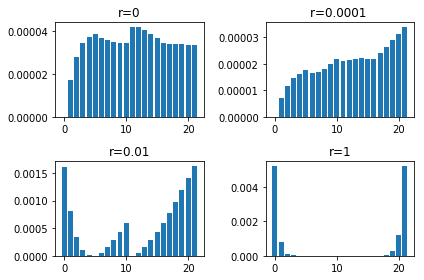

In [18]:
fig , ax =plt.subplots(2,2)
V_0 = V(k, ln_Pa, ln_Pb , ln_Pl , ln_Pu , L , gamma , 0 , p)
V_1 = V(k, ln_Pa, ln_Pb , ln_Pl , ln_Pu , L , gamma , 0.0001 , p)
V_2 = V(k, ln_Pa, ln_Pb , ln_Pl , ln_Pu , L , gamma , 0.01 , p)
V_3 = V(k, ln_Pa, ln_Pb , ln_Pl , ln_Pu , L , gamma , 1 , p)

N = ln_Pu - ln_Pl -1
ax[0,0].bar(np.arange(2*N+2), V_0-min(V_0) )
ax[0,0].set_title( "r=0")

ax[0,1].bar(np.arange(2*N+2),V_1 - min(V_1) )
ax[0,1].set_title( "r=0.0001 ")

ax[1,0].bar(np.arange(2*N+2),V_2 - min(V_2))
ax[1,0].set_title( "r=0.01")

ax[1,1].bar(np.arange(2*N+2),V_3 - min(V_3))
ax[1,1].set_title( "r=1")
plt.tight_layout()

In [19]:
V_3 

array([5.23004876e-03, 7.96504030e-04, 1.21410178e-04, 1.86140933e-05,
       2.96179266e-06, 5.79919300e-07, 9.68994947e-08, 5.23873593e-08,
       1.72739681e-07, 7.47666989e-07, 3.27212286e-06, 6.76368433e-07,
       3.19980544e-07, 2.92713176e-07, 4.06240597e-07, 9.38220462e-07,
       3.27212286e-06, 1.43258089e-05, 6.27212280e-05, 2.74606085e-04,
       1.20228040e-03, 5.26382421e-03])

In [20]:
V_3

array([5.23004876e-03, 7.96504030e-04, 1.21410178e-04, 1.86140933e-05,
       2.96179266e-06, 5.79919300e-07, 9.68994947e-08, 5.23873593e-08,
       1.72739681e-07, 7.47666989e-07, 3.27212286e-06, 6.76368433e-07,
       3.19980544e-07, 2.92713176e-07, 4.06240597e-07, 9.38220462e-07,
       3.27212286e-06, 1.43258089e-05, 6.27212280e-05, 2.74606085e-04,
       1.20228040e-03, 5.26382421e-03])

In [23]:
fig=plt.figure(figsize=(8,8))
ax =plt.subplot(projection ="3d")
x1 = np.arange(N+1)
x2 = np.arange(N+1)+1
y1 = -k*np.ones(N+1)
y2 =  k*np.ones(N+1)
ax.bar3d(x1,y1,1,dx=0.5,dy=0.5 ,dz=V_1[:N+1] - min(V_1))
ax.bar3d(x2,y2,1,dx=0.5,dy=0.5 ,dz=V_1[N+1:] - min(V_1))
plt.show()

ValueError: Unknown projection '3d'

In [22]:
fig=plt.figure(figsize=(8,8))
ax =plt.subplot(projection ="3d")
x1 = np.arange(N+1)
x2 = np.arange(N+1)+1
y1 = -k*np.ones(N+1)
y2 =  k*np.ones(N+1)
ax.bar3d(x1,y1,1,dx=0.5,dy=0.5 ,dz=V_0[:N+1] - min(V_0))
ax.bar3d(x2,y2,1,dx=0.5,dy=0.5 ,dz=V_0[N+1:] - min(V_0))
plt.show()

ValueError: Unknown projection '3d'

In [24]:
V_array

array([0.00523005, 0.00524758, 0.00525829, 0.00526445, 0.00526757,
       0.00526867, 0.00526702, 0.00526593, 0.0052652 , 0.00526471,
       0.00526439, 0.00527211, 0.00527186, 0.00527071, 0.00526896,
       0.00526681, 0.00526439, 0.00526417, 0.00526403, 0.00526393,
       0.00526387, 0.00526382])

## Starting from origin
Using the above result , we can compute the expected reward that starting from the origin :

$$
V( S^* = 1 , M = 0) = \mathbb{E}_{(1,0)}( e^{- r \tau}  \; ; \; S^*_\tau = S^*_0 e^\delta) \big[
V(e^\delta ,k) + f_X(e^\delta, 1) \big] + \mathbb{E}_{(1,0)}( e^{- r \tau}  \; ; \; S^*_\tau = S^*_0 e^{-\delta}) \big[
V(e^{-\delta},-k) + S^*e^{M-\delta} f_Y(e^{-\delta},1) \big]
$$

Let $l = \frac{\ln P_l }{\delta} < 0$ and $ u = \frac{\ln P_u }{\delta} > 0$ .
After enumeration ,
$ (e^{-\delta} , -k) \Rightarrow -l-1 \; , \;   (e^\delta , k) \Rightarrow N-l+1 $ ,
the desired value becomes

$$
V(  S^* = 1 , M = 0   ) = A\big[
V(N-l+1) + f_X(N-l) \big] + B \big[
V(-l-1) + S(l)f_Y(-l) \big]
$$

where $ A = \mathbb{E}_{(1,0)}( e^{- r \tau}  \; ; \; S^*_\tau = S^*_0 e^\delta)$ and $B = \mathbb{E}_{(1,0)}( e^{- r \tau}  \; ; \; S^*_\tau = S^*_0 e^{-\delta}) $ can be computed by the formula in previous part .

In [25]:
def V0(k, ln_Pa, ln_Pb ,  ln_Pl , ln_Pu , L , gamma , r , p):
    N = ln_Pu - ln_Pl -1
    l = ln_Pl
    V_array  = V(k, ln_Pa, ln_Pb , ln_Pl ,ln_Pu , L , gamma , r , p)
    M_A = 1
    M_B = -1
    A = ( np.exp(a_p(r,p,k)*(M_A+k+1)) - np.exp(a_m(r,p,k)*(M_A+k+1)) )/(  np.exp(a_p(r,p,k)*(2*k+2 )) - np.exp(a_m(r,p,k)*(2*k+2 )) )
    B = ( np.exp(a_p(r,p,k)*(M_B-k-1)) - np.exp(a_m(r,p,k)*(M_B-k-1)) )/(  np.exp(a_p(r,p,k)*(-2*k-2) ) - np.exp(a_m(r,p,k)*(-2*k-2) ) )
    fX =f_X(N-l,N,k,ln_Pa,ln_Pb,ln_Pl , L , gamma)
    fY =f_Y(-l,N,k,ln_Pa,ln_Pb,ln_Pl , L , gamma)
    return A*( V_array[N-l+1] + fX ) + B*( V_array[-l-1] + fY )

In [28]:
V0(k, -2, 5 , -1  , 10 , L , gamma , 0 , p) , V0(k, -2, 2  , -3 , 5  , L , gamma , r , p)

(0.0066853513720297585, 0.0038283307761520034)